In [0]:

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
input_size = 32*32*3
hidden_sizes = [1024, 256]
output_size = 10

# Build a feed-forward network
model1 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size)
                      )


model2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size)
                      )


In [0]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

In [0]:
def calculateTestLoss(images,labels):
  log =  nn.LogSoftmax(dim=1)
  images = images.view(images.shape[0], -1)
  output1 = model1(images)
  output2 = model2(images)
  averagedOutputs = (output1+output2)/2
  logps1 = log(output1)
  logps2 = log(output2)
  logpsAverage = log(averagedOutputs)
  loss = criterion(logpsAverage, labels) + 0.001 * kl
  return loss
  


In [0]:
def klIndependence(outputs1,outputs2):
  softmax = nn.Softmax(dim=1)
  probabilitiesModel1 = softmax(outputs1)
  probabilitiesModel2 = softmax(outputs2)
  averageProbabilities = (probabilitiesModel1+probabilitiesModel2)/2
  products = probabilitiesModel1*probabilitiesModel2
  rightTerm = torch.log2(averageProbabilities /(products+1e-7))
  kl = (rightTerm*averageProbabilities).sum()
  if kl < 0:
    print("distance negative")
    return 0
  return kl

In [0]:
import math
def diversityMeasures(predicted1,predicted2,labels):


  Qstatistic = doubleFault = disagreementMeasure = correlation = kappaStatistic =-50


  #both predict correctly N11
  a = predicted1 == labels 
  b = predicted2 == labels 
  N11 = a & b
  N11 = (a & b).sum().item()
  #Only the first classifies incorrectly N10
  a = predicted1 == labels 
  b = predicted2 != labels 
  N10 = (a & b).sum().item()
  #Only the second classifies incorrectly N01
  a = predicted1 != labels 
  b = predicted2 == labels 
  N01 = (a & b).sum().item()
  #both classify incorrectly
  a = predicted1 != labels 
  b = predicted2 != labels 
  N00 = (a & b).sum().item()


  if ((N11*N00) + (N01*N10)) != 0:
    Qstatistic = ((N11 * N00) - (N01 * N10))/((N11*N00) + (N01*N10))


  disagreementMeasure = (N01 + N10)/(N11 + N10 + N01 + N00)

  if ((N11+N10)* (N01+N00) * (N11*N01)* (N10+N00)) != 0   :
    correlation = (N11 * N00 - N01 * N10) / (math.sqrt((N11+N10)* (N01+N00) * (N11*N01)* (N10+N00)))

  doubleFault = N00/(N11 + N10 + N01 + N00)

  if (((N11+N10)*(N01 + N00)) + ((N11 + N01) * (N10 + N00))) != 0:
    kappaStatistic = (2 * ((N11*N00) - N01 * N10)) / (((N11+N10)*(N01 + N00)) + ((N11 + N01) * (N10 + N00)))
  
  return doubleFault,Qstatistic,disagreementMeasure,correlation,kappaStatistic


In [0]:
distancesTrain,distancesTest,trainlosses1,trainlosses2,testlosses,measures = [],[],[],[],[],[]

In [0]:


epochs = 2
for e in range(epochs):
  
    running_loss1 = 0
    running_loss2 = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        output1 = model1(images)
        output2 = model2(images)


        kl = klIndependence(output1,output2)
        distancesTrain.append(kl)



        if kl < 0:
          print("negative kl")
          break


        log =  nn.LogSoftmax(dim=1)
        output1 = log(output1)
        output2 = log(output2)

        ps1 = torch.exp(output1)
        ps2 = torch.exp(output2)


        
        y1 = torch.argmax(ps1, dim=1)
        y2 = torch.argmax(ps2, dim=1)

        measure = diversityMeasures(y1,y2,labels)

        measures.append(measure)


        loss1 = criterion(output1, labels) + 0.001 * kl
        loss2 = criterion(output2, labels) + 0.001 * kl
        


        loss1.backward(retain_graph=True)
        loss2.backward()

        
        #And optimizes its weights here
        optimizer1.step()
        optimizer2.step()
        
        running_loss1 += loss1.item()
        running_loss2 += loss2.item()


        trainlosses1.append(loss1.item())
        trainlosses2.append(loss2.item())


        
    else:
      runningloss_test = 0

      
      print("Training Loss Model 1=", running_loss1/len(trainloader))
      print("Training Loss Model 2=", running_loss2/len(trainloader))
      
    

      correct_count1,correct_count2,correct_countCombined, all_count = 0, 0,0,0
      for images,labels in valloader:

        lossTest = calculateTestLoss(images,labels)
        runningloss_test += lossTest.item()
        testlosses.append(lossTest.item())


        for i in range(len(labels)):
          img = images[i].view(1, 32*32*3)
          true_label = labels.numpy()[i]
        
          with torch.no_grad():
            output1 = model1(img)
            output2 = model2(img)
            averagedOutputs = (output1+output2)/2

            distance = klIndependence(output1,output2)
            distancesTest.append(distance)

            logps1 = log(output1)
            logps2 = log(output2)
            logpsAverage = log(averagedOutputs)

            

          
          ps1 = torch.exp(logps1)
          ps2 = torch.exp(logps2)
          psAveraged = torch.exp(logpsAverage)

          probab = list(ps1.numpy()[0])
          pred_label1 = probab.index(max(probab))
          

          if(true_label == pred_label1):
            correct_count1 += 1


          probab = list(ps2.numpy()[0])
          pred_label2 = probab.index(max(probab))
          true_label = labels.numpy()[i]

          if(true_label == pred_label2):
            correct_count2 += 1



          

          
          probab = list(psAveraged.numpy()[0])
          pred_label = probab.index(max(probab))
          true_label = labels.numpy()[i]

          if(true_label == pred_label):
            correct_countCombined += 1


          #measures.append(diversityMeasures(pred_label1,pred_label2,true_label))

          all_count += 1


      

      
      

      #print("Number Of Images Tested =", all_count)
      print("\nModel 1 Accuracy =", (correct_count1/all_count))
      print("\nModel 2 Accuracy =", (correct_count2/all_count))
      print("\nEnsemble Accuracy =", (correct_countCombined/all_count))
   

Training Loss Model 1= 2.4032178028770117
Training Loss Model 2= 2.4097813236743897

Model 1 Accuracy = 0.3616

Model 2 Accuracy = 0.3606

Ensemble Accuracy = 0.362
Training Loss Model 1= 2.050802733587182
Training Loss Model 2= 2.0559949435846274

Model 1 Accuracy = 0.4161

Model 2 Accuracy = 0.4121

Ensemble Accuracy = 0.4154


In [0]:
testMeasures = []

In [0]:
for images,labels in valloader:
  with torch.no_grad():
    images = images.view(images.shape[0], -1)
    output1 = model1(images)
    output2 = model2(images)
    logps1 = log(output1)
    logps2 = log(output2)
    ps1 = torch.exp(logps1)
    ps2 = torch.exp(logps2)

    y1 = torch.argmax(ps1, dim=1)
    y2 = torch.argmax(ps2, dim=1)

    measure = diversityMeasures(y1,y2,labels)

    testMeasures.append(measure)


  


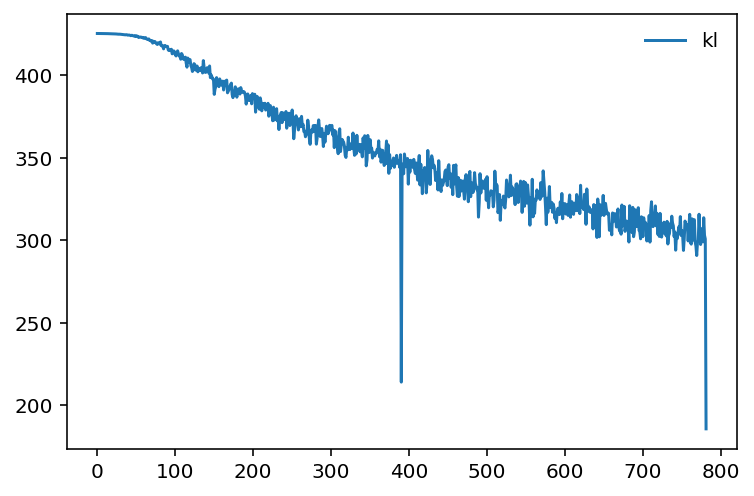

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


plt.plot(distancesTrain, label='kl')

plt.legend(frameon=False)




In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

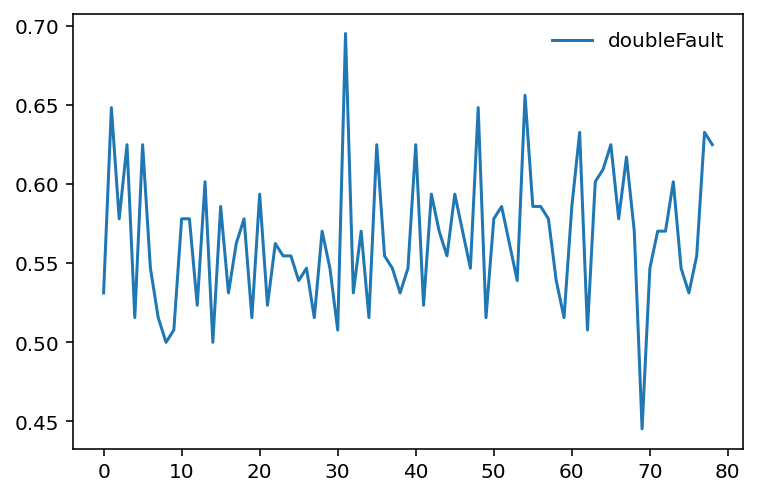

In [0]:
doubleFault = [i[0] for i in testMeasures]
plt.plot(doubleFault, label='doubleFault')

plt.legend(frameon=False)


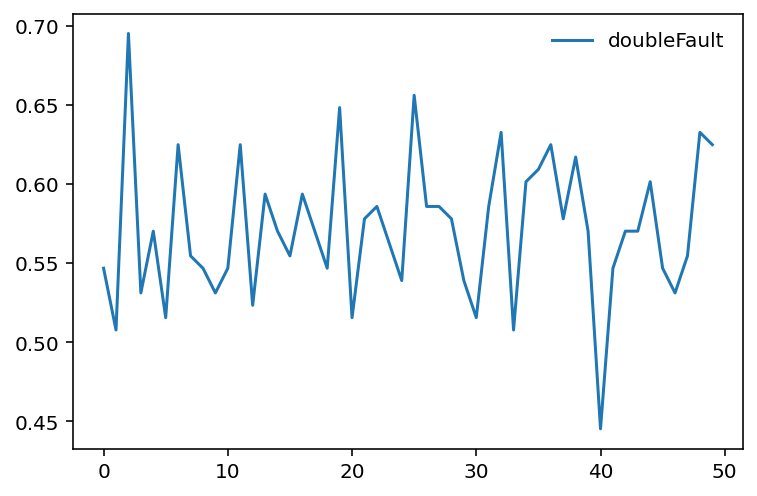

In [0]:
plt.plot(doubleFault[-50:], label='doubleFault')

plt.legend(frameon=False)

In [0]:
sum(doubleFault)/len(doubleFault)

0.5658623417721519

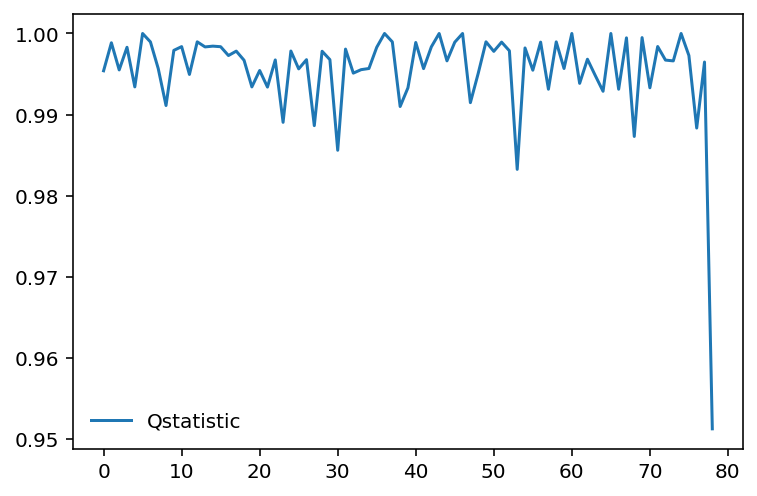

In [0]:
 Qstatistic = [i[1] for i in testMeasures if i[1] >= 0]
 plt.plot( Qstatistic, label='Qstatistic')

plt.legend(frameon=False)

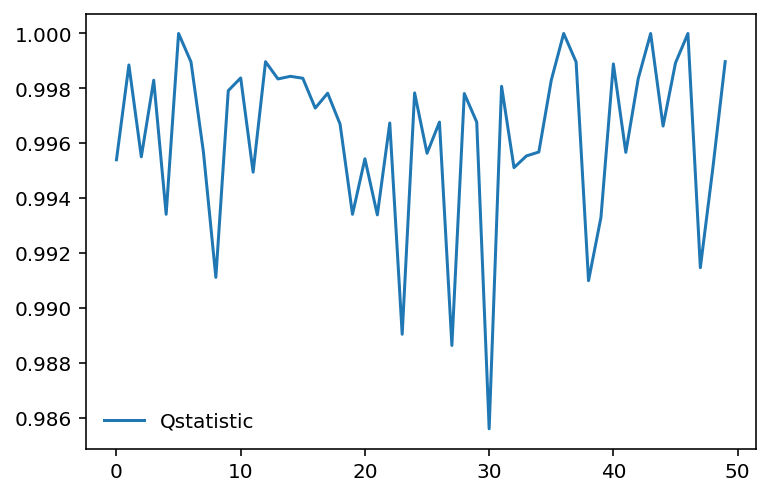

In [0]:
plt.plot( Qstatistic[0:50], label='Qstatistic')

plt.legend(frameon=False)

In [0]:
sum(Qstatistic)/len(Qstatistic)

0.9955144070720371

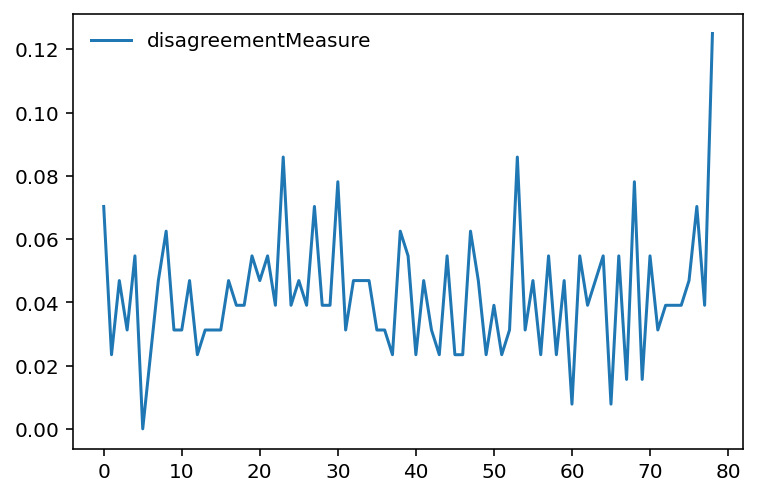

In [0]:
 disagreementMeasure = [i[2] for i in testMeasures if i[2] >= 0]
 plt.plot( disagreementMeasure, label='disagreementMeasure')

plt.legend(frameon=False)

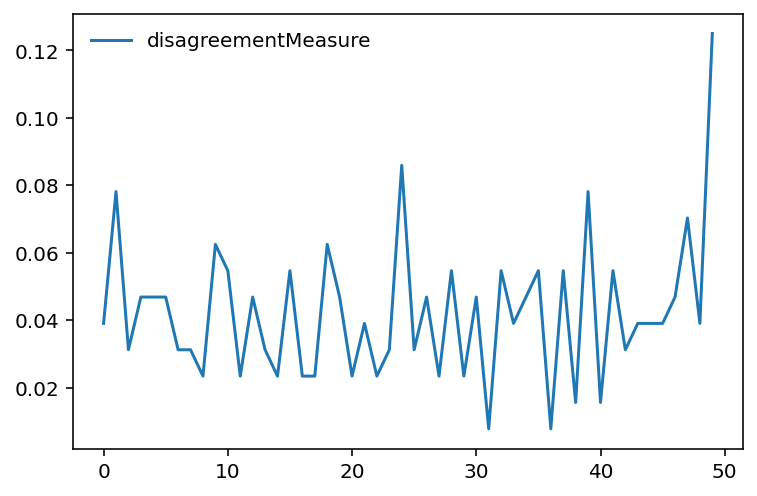

In [0]:
plt.plot( disagreementMeasure[-50:], label='disagreementMeasure')

plt.legend(frameon=False)

In [0]:
sum(disagreementMeasure)/len(disagreementMeasure)

0.042325949367088604

In [0]:
correlation = [i[3] for i in testMeasures if i[3] >= 0]

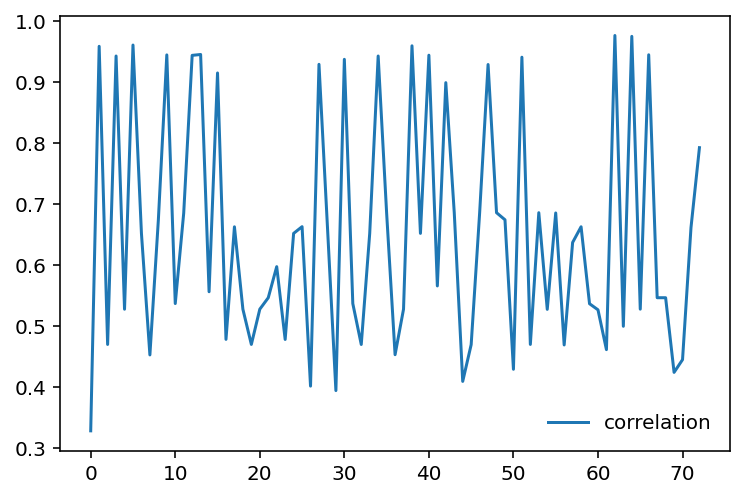

In [0]:
plt.plot( correlation, label='correlation')

plt.legend(frameon=False)

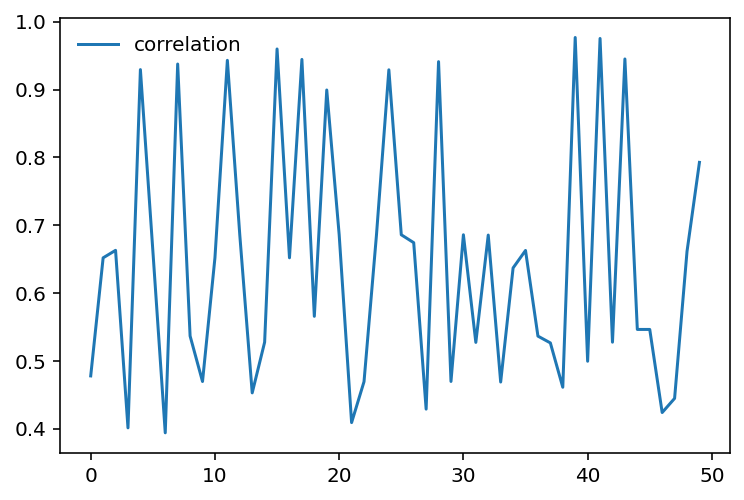

In [0]:
plt.plot( correlation[-50:], label='correlation')

plt.legend(frameon=False)

In [0]:
sum(correlation)/len(correlation)

0.6524667973047522

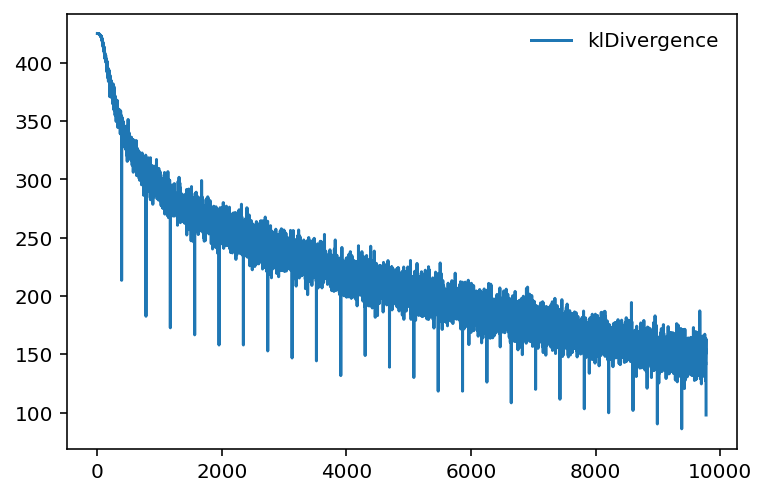

In [0]:
 plt.plot( distancesTrain, label='klDivergence')

 plt.legend(frameon=False)

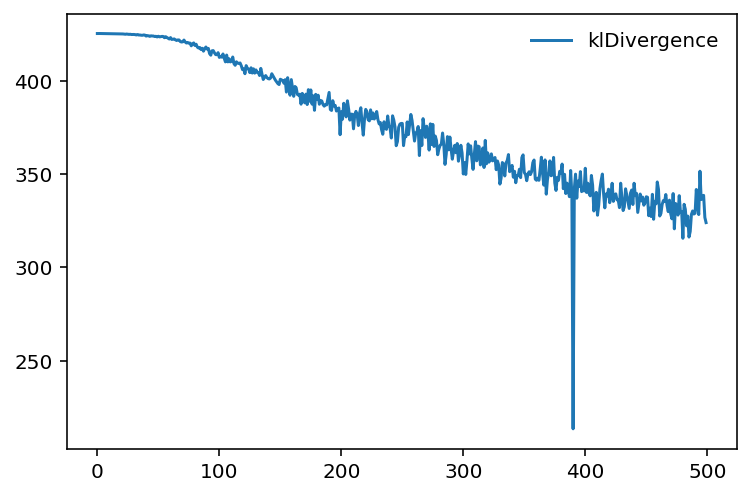

In [0]:
 plt.plot(distancesTrain[0:500], label='klDivergence')

 plt.legend(frameon=False)




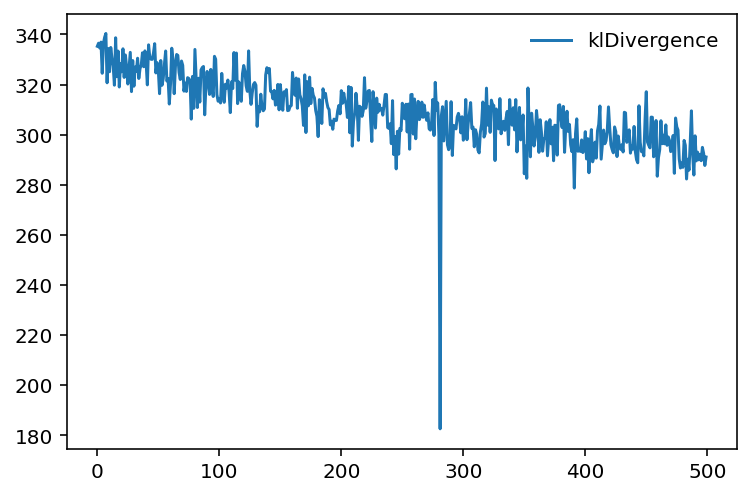

In [0]:
 plt.plot(distancesTrain[500:1000], label='klDivergence')

 plt.legend(frameon=False)

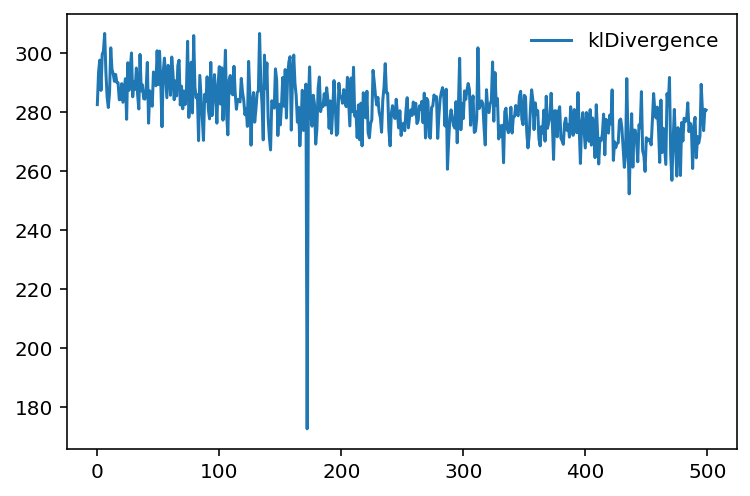

In [0]:
 plt.plot(distancesTrain[1000:1500], label='klDivergence')

 plt.legend(frameon=False)

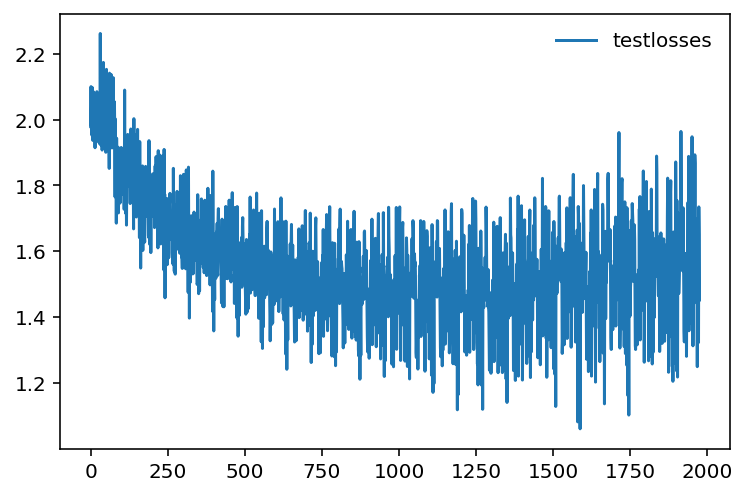

In [0]:
 plt.plot( testlosses, label='testlosses')

 plt.legend(frameon=False)

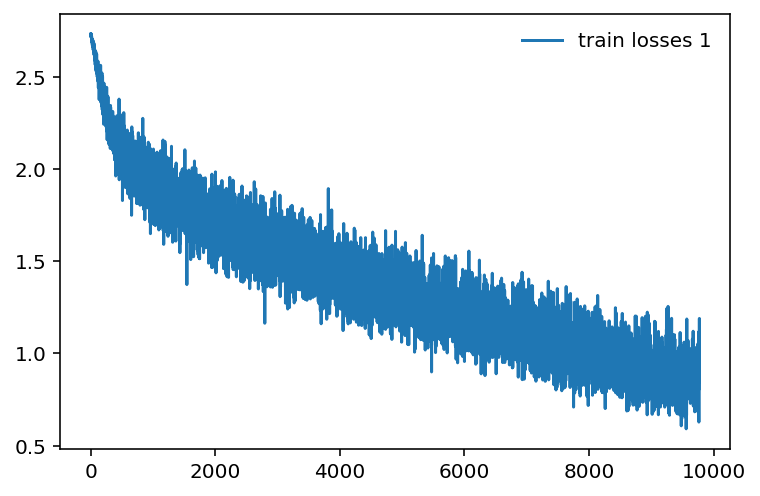

In [0]:
 plt.plot( trainlosses1, label='train losses 1')

 plt.legend(frameon=False)

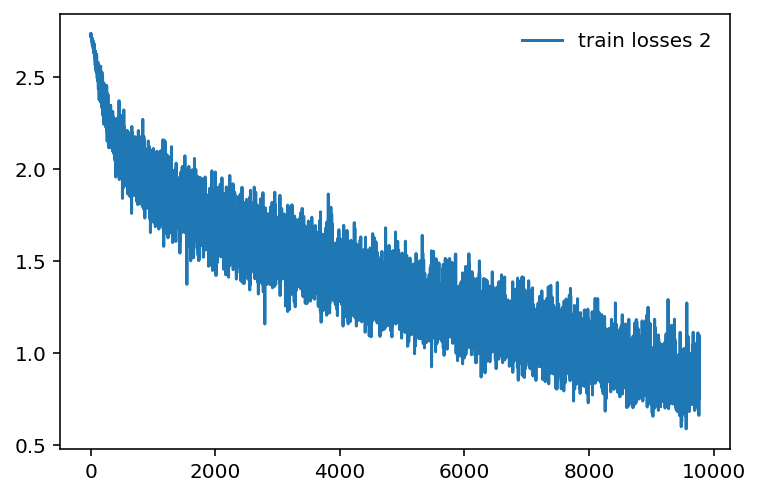

In [0]:
 plt.plot( trainlosses2, label='train losses 2')

 plt.legend(frameon=False)